<a href="https://colab.research.google.com/github/Nyaina-6/Apprentissage/blob/main/RN-Gan-Autoencodeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist


## Chargement des données

In [ ]:
# Chargement et prétraitement des données
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step


## Autoencodeur

In [ ]:
latent_dim = 64

In [ ]:
# Création de l'autoencodeur


encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
latent_space = layers.Dense(latent_dim, activation='relu')(x)

encoder = Model(encoder_inputs, latent_space, name='encoder')

latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')

autoencoder_outputs = decoder(encoder(encoder_inputs))
autoencoder = Model(encoder_inputs, autoencoder_outputs, name='autoencoder')

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Training


In [ ]:
# Entraînement de l'autoencodeur
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 11s 11ms/step - loss: 0.1665 - val_loss: 0.0880
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0821 - val_loss: 0.0764
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0754 - val_loss: 0.0729
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0727 - val_loss: 0.0711
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0709 - val_loss: 0.0698
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0699 - val_loss: 0.0689
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0691 - val_loss: 0.0682
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0687 - val_loss: 0.0680
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0682 - val_loss: 0.0677
Epoch 10/10
469/469 [==============================] - 4s 10ms/step - loss: 0.0679 - val_loss: 0.0

313/313 [==============================] - 1s 2ms/step


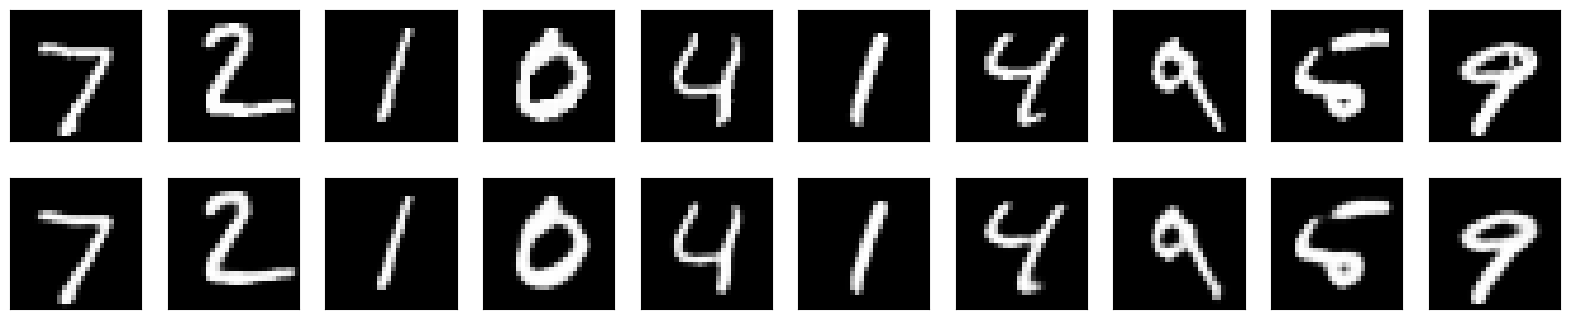

In [ ]:
# Génération d'images avec l'autoencodeur
decoded_imgs = autoencoder.predict(x_test)

# Affichage des images générées
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()


## GAN

In [ ]:
# Augmenter la taille du lot
batch_size = 128

# Réduire le taux d'apprentissage
learning_rate = 0.0001

# Architecture du générateur
generator = tf.keras.Sequential([
    layers.Dense(7*7*256, activation='relu', input_shape=(latent_dim,)),
    layers.Reshape((7, 7, 256)),
    layers.BatchNormalization(),
    #layers.Conv2DTranspose(256, 3, activation='relu', strides=1, padding='same'),
    #layers.BatchNormalization(),
    layers.Conv2DTranspose(128, 3, activation='relu', strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(1, 3, activation='sigmoid', strides=2, padding='same')
])

# Architecture du discriminateur
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, 3, activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
    #layers.Conv2D(256, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)


# Compilation des modèles
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')
discriminator.trainable = False
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')


# Training

In [ ]:
epochs = 10
for epoch in range(epochs):
    for _ in range(len(x_train) // batch_size):
        noise = tf.random.normal([batch_size, latent_dim])
        generated_images = generator(noise)

        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

        x_combined = tf.concat([real_images, generated_images], axis=0)
        y_combined = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_combined, y_combined)

        noise = tf.random.normal([batch_size, latent_dim])
        y_mislabeled = tf.ones((batch_size, 1))

        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_mislabeled)

    print(f"Epoch {epoch+1}, d_loss: {d_loss}, g_loss: {g_loss}")


Epoch 1, d_loss: 0.00019745371537283063, g_loss: 1.9653156995773315
Epoch 2, d_loss: 0.0018737385980784893, g_loss: 0.11821599304676056
Epoch 3, d_loss: 0.017519883811473846, g_loss: 5.160614013671875
Epoch 4, d_loss: 0.044842883944511414, g_loss: 17.58283233642578
Epoch 5, d_loss: 0.05037916824221611, g_loss: 12.85348129272461
Epoch 6, d_loss: 0.03915589302778244, g_loss: 7.502131462097168
Epoch 7, d_loss: 0.05209740996360779, g_loss: 10.00201416015625
Epoch 8, d_loss: 0.057823244482278824, g_loss: 1.6714203357696533
Epoch 9, d_loss: 0.05965379625558853, g_loss: 6.707587242126465
Epoch 10, d_loss: 0.05463173985481262, g_loss: 11.439292907714844


## Génération d'images

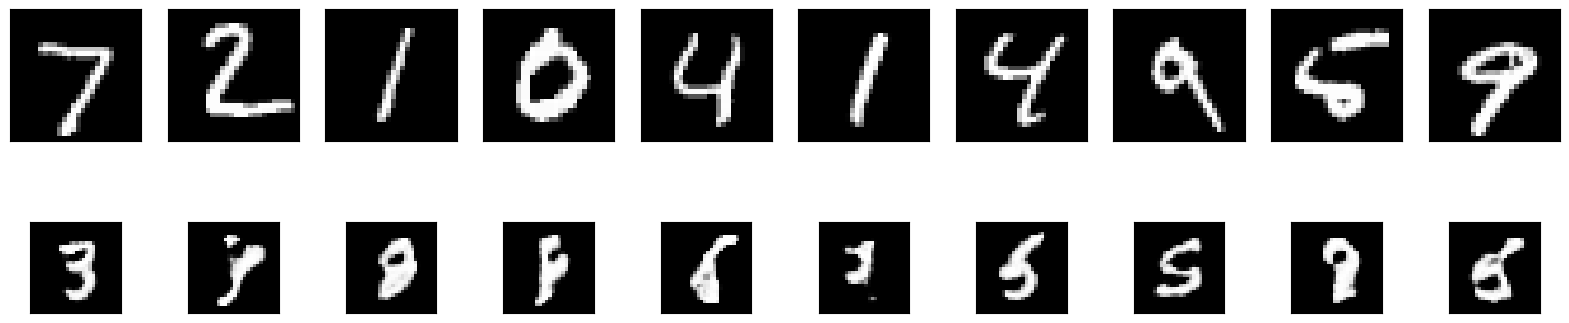

In [ ]:

# Génération d'images avec le GAN
noise = tf.random.normal([10, latent_dim])
generated_images = generator(noise)

# Affichage des images générées
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(generated_images[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Affichage des images intermediare générées
# AE

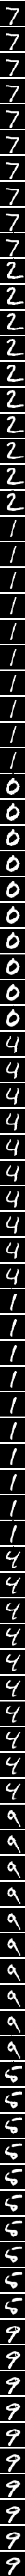

In [ ]:
n_steps = 10
# Affichage des images générées par l'autoencodeur
plt.figure(figsize=(20, 6*n_steps*n))
for i in range(n):
    # Interpolation linéaire entre l'image originale et l'image reconstruite
    for step in range(n_steps):
        interpolation = x_test[i] + (decoded_imgs[i] - x_test[i]) * (step / n_steps)

        ax = plt.subplot(n_steps*n, 3, i*n_steps*3 + 3*step + 1)
        plt.imshow(interpolation.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if step == 0:
            ax.set_title("Étape 0")
        elif step == n_steps - 1:
            ax.set_title(f"Étape {n_steps - 1}")

plt.tight_layout()
plt.show()




# Gan

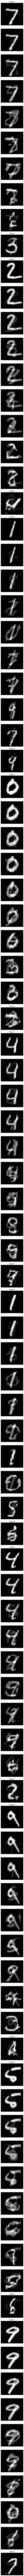

In [ ]:
# Affichage des images générées par le GAN
plt.figure(figsize=(10, 3*n_steps*n))
for i in range(n):
    # Interpolation linéaire entre l'image originale et l'image générée par le GAN
    for step in range(n_steps):
        noise = tf.random.normal([1, latent_dim])  # Utilisation d'un seul bruit pour la cohérence
        generated_image = generator(noise)
        interpolation = x_test[i] + (generated_image.numpy() - x_test[i]) * (step / n_steps)

        ax = plt.subplot(n_steps*n, 3, i*n_steps*3 + 3*step + 1)
        plt.imshow(interpolation.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if step == 0:
            ax.set_title("Étape 0")
        elif step == n_steps - 1:
            ax.set_title(f"Étape {n_steps - 1}")

plt.tight_layout()
plt.show()